# Spotify Genre Prediction

### 1. Preprocesamiento y Transformación

- Importar librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from hdbscan import HDBSCAN
from sklearn.neighbors import NearestNeighbors

- Importar CSV

In [3]:
df = pd.read_csv('train.csv')

- Eliminar las filas duplicadas

In [4]:
df_cleaned = df.drop_duplicates(subset='id', keep='last')

- Eliminar columnas irrelevantes:
  - *Categóricas*: IDs, ruidos y etiquetas repetidas (sin valor predictivo).
  - *'mode', 'key', 'time_signature'*: Baja importancia en el EDA para identificar géneros.
  - *'loudness'*: Alta correlación con 'energy' (0.598), lo que genera redundancia.

In [5]:
columns_to_drop = ['type', 'id', 'uri', 'track_href', 'analysis_url', 'genre', 'song_name', 'title', 'Unnamed: 0', 'Id', 'mode', 'key', 'time_signature', 'loudness']

df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

- Normalizar datos

In [6]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

- Guardar dataset limpio

In [7]:
df_scaled.to_csv("train_clean.csv", index=False)
df_scaled.head()

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1.640192,-0.392062,1.839910,-0.491316,-0.767334,-0.715319,1.317208,1.781719,-0.957013
1,-1.328201,1.085896,-0.051699,-0.549142,-0.331527,2.360748,-0.998500,-0.394293,-0.311599
2,0.296738,-0.386609,1.475835,2.263485,-0.767334,-0.257060,1.248721,1.106304,0.174947
3,-1.270624,0.698682,-0.787765,-0.456749,1.425152,-0.171882,-1.378173,1.157778,0.663642
4,-1.686455,0.616876,-0.281225,-0.358321,-0.767334,-0.506916,-0.459167,2.293609,-0.279109


### 2. Diseño, Entrenamiento y Evaluación del Modelo

In [8]:
df_scaled = pd.read_csv("train_clean.csv")

#### Aplicar PCA

- Determina el número optimo de componentes

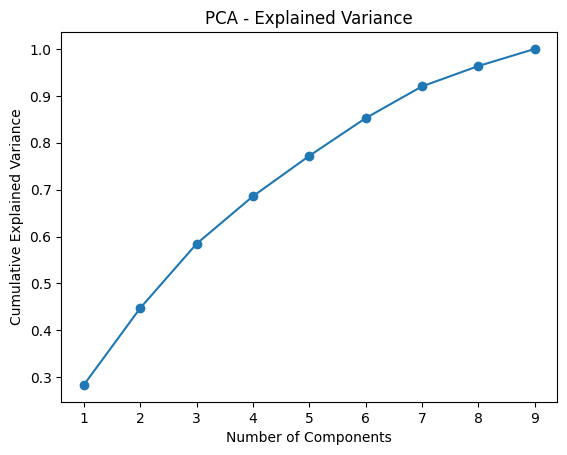

In [9]:
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

# Determine optimal number of components
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance")
plt.show()

- Reducimos dimensiones usando 8 componentes el numero de coponentes que explica el 95% del conjunto

In [10]:
pca_opt = PCA(n_components=8)
df_pca_opt = pca_opt.fit_transform(df_scaled)

####  Aplicar K-Means

- Usamos la mejor K a través del método del codo

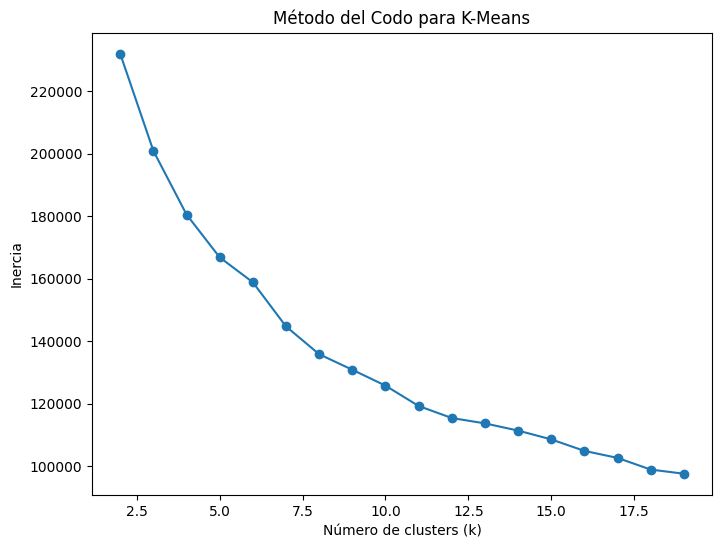

In [11]:
best_k, best_inertia = 2, float('inf')
inertia_values = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca_opt)
    inertia_values.append(kmeans.inertia_)  # Guardar la inercia para cada valor de k

# Graficar la inercia en función de k
plt.figure(figsize=(8, 6))
plt.plot(range(2, 20), inertia_values, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.show()

- Aplicar K-Means con el mejor K

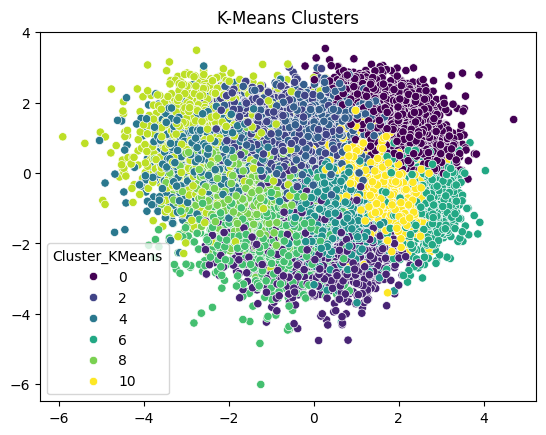

In [12]:
kmeans = KMeans(n_clusters=11, random_state=42)
df_scaled['Cluster_KMeans'] = kmeans.fit_predict(df_pca_opt)

sns.scatterplot(x=df_pca_opt[:, 0], y=df_pca_opt[:, 1], hue=df_scaled['Cluster_KMeans'], palette="viridis")
plt.title("K-Means Clusters")
plt.show()

#### Aplicar DBSCAN

- Optimizar DBSCAN con NearestNeighbors para mejores hiperparámetros

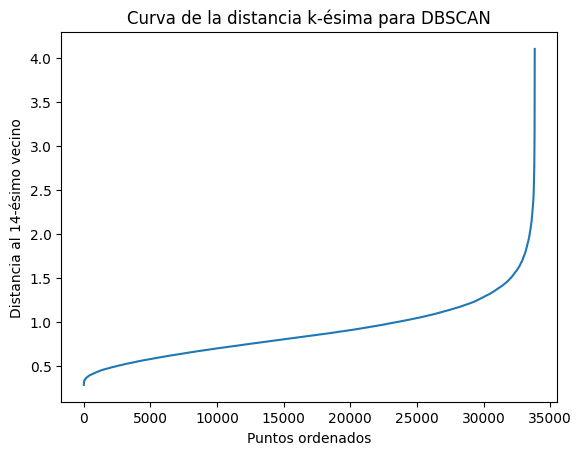

In [13]:
min_samples = 14

# Calcular distancias a los min_samples-ésimos vecinos más cercanos
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(df_pca_opt)
distances, indices = neighbors.kneighbors(df_pca_opt)

# Ordenar y graficar las distancias al k-ésimo vecino más cercano
distances = np.sort(distances[:, -1])  # Última columna tiene la distancia al k-ésimo vecino
plt.plot(distances)
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {min_samples}-ésimo vecino")
plt.title("Curva de la distancia k-ésima para DBSCAN")
plt.show()

- Entrena DBSCAN con los mejores hiperparámetros

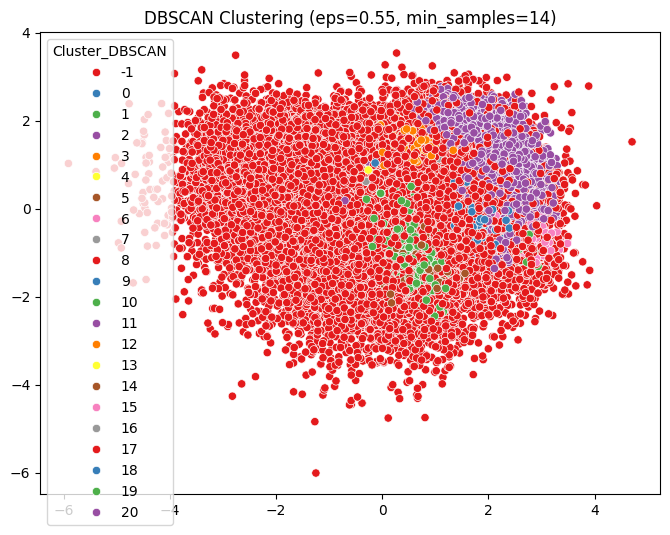

In [14]:
dbscan = DBSCAN(eps=0.55, min_samples=14)
df_scaled['Cluster_DBSCAN'] = dbscan.fit_predict(df_pca_opt)
np.unique(df_scaled['Cluster_DBSCAN'], return_counts=True)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca_opt[:, 0], y=df_pca_opt[:, 1], hue=df_scaled['Cluster_DBSCAN'], palette="Set1")
plt.title(f"DBSCAN Clustering (eps={dbscan.eps}, min_samples={dbscan.min_samples})")
plt.show()

#### Aplicar HDBSCAN

- Entrenar modelo

In [15]:
# Elegir valores basados en el análisis
min_cluster_size = 14
min_samples = 8

hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
df_scaled['Cluster_HDBSCAN'] = hdbscan.fit_predict(df_pca_opt)

C:\Users\Andreu Picornell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Andreu Picornell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


- Visualización de los resultados

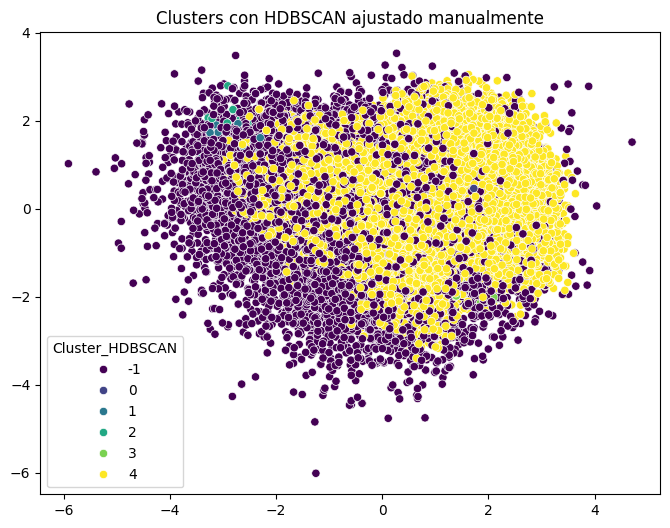

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca_opt[:, 0], y=df_pca_opt[:, 1], hue=df_scaled['Cluster_HDBSCAN'], palette="viridis")
plt.title("Clusters con HDBSCAN ajustado manualmente")
plt.show()

#### Evaluar modelos

- Evaluación KMeans

In [17]:
silhouette_kmeans = silhouette_score(df_pca_opt, df_scaled['Cluster_KMeans'])
davies_kmeans = davies_bouldin_score(df_pca_opt, df_scaled['Cluster_KMeans'])
calinski_kmeans = calinski_harabasz_score(df_pca_opt, df_scaled['Cluster_KMeans'])

print(f"K-Means: Silhouette {silhouette_kmeans}, Davies-Bouldin {davies_kmeans}, Calinski-Harabasz {calinski_kmeans}")

K-Means: Silhouette 0.18324941775332312, Davies-Bouldin 1.5063326580229797, Calinski-Harabasz 4939.977806748899


- Evaluación DBSCAN

In [18]:
silhouette_dbscan = silhouette_score(df_pca_opt, df_scaled['Cluster_DBSCAN'])
davies_dbscan = davies_bouldin_score(df_pca_opt, df_scaled['Cluster_DBSCAN'])
calinski_dbscan = calinski_harabasz_score(df_pca_opt, df_scaled['Cluster_DBSCAN'])

print(f"DBSCAN: Silhouette {silhouette_dbscan}, Davies-Bouldin {davies_dbscan}, Calinski-Harabasz {calinski_dbscan}")

DBSCAN: Silhouette -0.32705110326941433, Davies-Bouldin 1.4963926128020986, Calinski-Harabasz 283.82696091910924


- Evaluacion HDBSCAN

In [19]:
silhouette_hdbscan = silhouette_score(df_pca_opt, df_scaled['Cluster_HDBSCAN'])
davies_hdbscan = davies_bouldin_score(df_pca_opt, df_scaled['Cluster_HDBSCAN'])
calinski_hdbscan = calinski_harabasz_score(df_pca_opt, df_scaled['Cluster_HDBSCAN'])

print(f"HDBSCAN: Silhouette {silhouette_hdbscan}, Davies-Bouldin {davies_hdbscan}, Calinski-Harabasz {calinski_hdbscan}")

HDBSCAN: Silhouette -0.05946880844355429, Davies-Bouldin 1.8363477921118037, Calinski-Harabasz 583.5820956362431


### 3. Resultados y conclusiones

Tras comparar los modelos, **K-Means** muestra el mejor equilibrio entre separación y cohesión de los clusters. Presenta un **Davies-Bouldin bajo (1.50)** y la mejor métrica **Calinski-Harabasz (4939.98)**, indicando clusters bien definidos. Aunque su **Silhouette Score (0.18)** es moderado, sigue siendo la opción más estable.  

Por otro lado, **DBSCAN y HDBSCAN generan demasiado ruido (-1 en muchas observaciones)**, lo que sugiere que no logran capturar una estructura clara en los datos.  


### 4. Líneas a futuro  
- **Refinar el preprocesamiento** mediante la reducción de dimensionalidad y el manejo de outliers.  
- **Explorar otros algoritmos**, como **Gaussian Mixture Models (GMM)** o **Agglomerative Clustering**, para evaluar posibles mejoras.  